#  Evaluation of BlueSTARR-predicted variant effects against benchmark(s)

We assess the accuracy of BlueSTARR model predictions by comparing its variant effect predictions to those generated experimentally through saturation mutagenesis via MPRA assays in [Kircher _et al_ (2019)](https://doi.org/10.1038/s41467-019-11526-w).

## Setup

### Imports

In [4]:
import polars as pl
import numpy as np
import pandas as pd
import duckdb
from pathlib import Path

### Paths to data and databases

In [5]:
PROJECT_ROOT = Path('/hpc/group/igvf')
DATA_ROOT = Path("../../igvf-pm")
DB_ROOT = PROJECT_ROOT / 'db'
MODELS = ['K562', 'A549-DMSO']
MUT_PRED_DBs = {k: DB_ROOT / f'Kircher-2019_{k}.parquet' for k in MODELS}
DATA_DIR = PROJECT_ROOT / 'benchmarks' / 'Kircher_et_al_2019'

## Load Kircher _et al_ (2019) data files

The columns in the files are the following (according to, and taken verbatim from, the [wiki accompanying the file deposition](https://osf.io/75b2m/wiki/Files/)):
1. **Chromosome** - Chromosome of the variant.
2. **Position** - Chromosomal position (GRCh38 or GRCh37) of the variant. _(We are using the GRCh38 coordinates)_
3. **Ref** - Reference allele of the variant (A, T, G, or C).
4. **Alt** - Alternative allele of the variant (A, T, G, or C). One base-pair deletions are represented as -.
5. **Tags** - Number of unique tags associated with the variant.
6. **DNA** - Count of DNA sequences that contain the variant (used for fitting the linear model).
7. **RNA** - Count of RNA sequences that contain the variant (used for fitting the linear model).
8. **Value** - Log2 variant expression effect derived from the fit of the linear model (coefficient).
9. **P-Value** - P-value of the coefficient.

In [6]:
mut_data = pl.scan_csv(DATA_DIR / "*" / "*.tsv", separator="\t",
                       has_header=True, null_values=["NA"], include_file_paths="file_path")

For parsing the file paths, the directory indicates the type of region (_enhancer_ or _promoter_, with the UCE being lumped in with enhancers). The filenames (i.e., base names) themselves have a prefix signifying the genome assembly version, the file extension as a suffix, and the part in between being the experiment. Most experiments correspond 1:1 to regions, but some include replicates, reverse strand, different protocols (time of harvesting, for example), etc. It appears that designations of replicate, protocol, etc are appended following either a dot or a dash.

In [7]:
mut_data = mut_data.filter(
    pl.col('Ref').str.len_bytes() == 1,
    pl.col('Alt').str.len_bytes() == 1,
    pl.col('Alt') != '-',
).with_columns(
    pl.col('Position').add(-1).alias('allele_pos'),
    (pl.lit('chr') + pl.col('Chromosome')).alias('chrom'),
    pl.col('Ref').alias('ref_allele'),
    pl.col('Alt').alias('alt_allele'),
    pl.col('P-Value').alias('p_value'),
    pl.col('file_path').str.extract(r'GRCh38_(.*).tsv$').alias('experiment'),
    pl.col('file_path').str.split('/').list.get(-2).alias('region_type')
).with_columns(
    pl.col('experiment').str.extract(r'^([^-.]+)').alias('region'),
).drop(['Ref', 'Alt', 'Position', 'Chromosome']).drop_nulls()

In [8]:
kircher_ntotal = len(mut_data.select(['chrom']).collect())
kircher_nmut = len(mut_data.select(['chrom', 'allele_pos', 'alt_allele']).unique().collect())
print(f"Total number of MPRA results: {kircher_ntotal:,}")
print(f"Total number of mutations with MPRA results: {kircher_nmut:,}")

Total number of MPRA results: 39,170
Total number of mutations with MPRA results: 29,444


## Merge with BlueSTARR mutation predictions

### BlueSTARR predictions from _in-silico_ saturated mutagenesis of Kircher _et al_ 2019 regions

In [9]:
mutpreds = {}
for model, db in MUT_PRED_DBs.items():
    mutpreds[model] = duckdb.read_parquet(str(db))
    print(f"Predictions from {model}: {mutpreds[model].count('chrom').fetchall()[0][0]:,}")

Predictions from K562: 29,532
Predictions from A549-DMSO: 29,532


### Join by chromosomal position and alternative allele

We include the reference allele as a sanity check. Including it in the join conditions in theory would be redundant with joining by chromosomal position. By omitting it from the join conditions, we can check that indeed the reference alleles are the same from both tables.

Kircher _et al_ (2019) use not only the effect size, but also the P-value and Tags columns for filtering. We therefore include both here.

In [10]:
bk_dfs = {}
for model, mutdb in mutpreds.items():
    blue_kircher = duckdb.sql(
        "select k.region_type, k.region, k.chrom, k.allele_pos, k.ref_allele, k.alt_allele, "
        "m.ref_allele as blue_ref_allele, m.log2FC, "
        "last(k.Value order by abs(k.Value)) as mpra_max_log2effect, "
        "last(k.p_value order by abs(k.Value)) as mpra_p_value, "
        "last(k.Tags order by abs(k.Value)) as mpra_tags "
        "from mut_data k, mutdb m "
        "where k.chrom = m.chrom "
        "and k.allele_pos = m.allele_pos and k.alt_allele = m.allele "
        "group by k.region_type, k.region, k.chrom, k.allele_pos, k.ref_allele, k.alt_allele, m.ref_allele, m.log2FC")
    bk_dfs[model] = blue_kircher.df()
    print(f"Number of MPRA results matched with BlueSTARR {model} predictions: {len(bk_dfs[model]):,} ({len(bk_dfs[model])/kircher_nmut:.1%})")


Number of MPRA results matched with BlueSTARR K562 predictions: 29,444 (100.0%)
Number of MPRA results matched with BlueSTARR A549-DMSO predictions: 29,444 (100.0%)


Sanity check: for every position, the reference alleles between Kircher _et al_ and BlueSTARR should be the same.

In [11]:
for model, bk_df in bk_dfs.items():
    ref_mismatched = bk_df.loc[bk_df['ref_allele'] != bk_df['blue_ref_allele']]
    print(f"Ref allele mismatches for {model}: {len(ref_mismatched):,}")

Ref allele mismatches for K562: 0
Ref allele mismatches for A549-DMSO: 0


## ROC display and AUC

### Define positive and negative classes

Kircher _et al_ (2019) calculate a p-value based on a linear regression model, and label positives (mutations having a significant effect) based on a p-value cut-off (p<1e-5). For the negative class (mutations without a significant effect) a cut-off on absolute effect size (at 0.05) is used. (Strictly speaking, Kircher _et al_ only give _"$log_2$ expression effect < 0.05"_, but we assume they meant _absolute_ expression effect.)

Additionally, labeling classes (as either a positive or a negative) requires a minimum Tag count. We use 10 as recommended in Kircher _et al_ (2019).

Kircher _et al_ (2019) don't explicitly mention whether there is a p-value cutoff as well for the negative class. We'll use a value that is several orders of magnitude higher than the maximum p-value for positives, but still quite low.

Note that this approach will leave some mutations unlabeled (those with low Tag count, and those with p-values in the "grey zone" between the two cut-offs).

In [12]:
def add_class_labels(df: pd.DataFrame,
                     Pval_pos: float,
                     Pval_neg: float,
                     abs_effect_neg: float = 0.05,
                     pos_label: str | None = None,
                     neg_label: str | None = None,
                     min_tags: int = 10,
                     label_col: str = 'label') -> pd.DataFrame:
    """
    Add class labels to a DataFrame based on MPRA p-values, effect sizes, and tag counts.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame containing MPRA data with columns for p-values, effect sizes, and tag counts.
    Pval_pos : float
        The p-value threshold for labeling positive mutations (e.g., p < 1e-5).
    Pval_neg : float
        The p-value threshold for labeling negative mutations (e.g., p > 0.01).
    abs_effect_neg : float, optional
        The maximum absolute effect size for labeling negative mutations (default is 0.05).
    pos_label : str or None, optional
        The label to assign to positive mutations. If None, a default label based on `Pval_pos` is used.
    neg_label : str or None, optional
        The label to assign to negative mutations. If None, a default label based on `Pval_neg` is used.
    min_tags : int, optional
        The minimum number of tags required to label a mutation (default is 10).
    label_col : str, optional
        The name of the column to store the labels (default is 'label').

    Returns
    -------
    pandas.DataFrame
        The input DataFrame with an additional column containing the assigned labels.

    Notes
    -----
    - Mutations with p-values below `Pval_pos` and tag counts greater than or equal to `min_tags` are labeled as positive.
    - Mutations with p-values above `Pval_neg`, absolute effect sizes below `abs_effect_neg`, and tag counts greater than or equal to `min_tags` are labeled as negative.
    - Mutations that do not meet the criteria for either positive or negative labels are left unlabeled (i.e., `None`).
    """
    df[label_col] = None
    if pos_label is None:
        pos_label = f"MPRA p<{Pval_pos}"
    if neg_label is None:
        neg_label = f"MPRA p>{Pval_neg}"
    df.loc[(df['mpra_p_value'] < Pval_pos) &
           (df['mpra_tags'] >= min_tags), label_col] = pos_label 
    df.loc[(df['mpra_p_value'] > Pval_neg) &
           (df['mpra_max_log2effect'].abs() < abs_effect_neg) &
           (df['mpra_tags'] >= min_tags), label_col] = neg_label    
    return df

In [41]:
Pval_pos = 1e-5
Pval_neg = 0.01
effect_neg = 0.05
pos_label = f"MPRA p<{Pval_pos}"
neg_label = f"MPRA p>{Pval_neg}"

In [42]:
bk_dfs = {
    model: add_class_labels(bk_df,
                            Pval_pos=Pval_pos,
                            Pval_neg=Pval_neg,
                            abs_effect_neg=effect_neg,
                            pos_label=pos_label, neg_label=neg_label).dropna(subset=['label'])
    for model, bk_df in bk_dfs.items()
}
bk_df = pd.concat(bk_dfs.values(), keys=bk_dfs.keys(), names=['model'])

### Subset predictions into those with positive and negative effects

We also create a set of all effects (regardless of direction) suitable for ROC analysis, which means we use the absolute predicted effect in $\log_2$ space.

In [43]:
bk_df_pos = bk_df.loc[bk_df['mpra_max_log2effect'] >= 0]
bk_df_neg = bk_df.loc[bk_df['mpra_max_log2effect'] < 0]
bk_df['abs_log2FC'] = bk_df['log2FC'].abs()

How many positives and negatives do we have?

In [44]:
bk_df_pos.groupby(['model', 'label'])['chrom'].count()

model      label       
A549-DMSO  MPRA p<1e-05    1804
           MPRA p>0.01     5789
K562       MPRA p<1e-05    1805
           MPRA p>0.01     5790
Name: chrom, dtype: int64

In [45]:
bk_df_neg.groupby(['model', 'label'])['chrom'].count()

model      label       
A549-DMSO  MPRA p<1e-05    2953
           MPRA p>0.01     4669
K562       MPRA p<1e-05    2954
           MPRA p>0.01     4668
Name: chrom, dtype: int64

In [46]:
bk_df.groupby(['model', 'label'])['chrom'].count()

model      label       
A549-DMSO  MPRA p<1e-05     4757
           MPRA p>0.01     10458
K562       MPRA p<1e-05     4759
           MPRA p>0.01     10458
Name: chrom, dtype: int64

### Visualize BlueSTARR predictions versus MPRA effect size

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

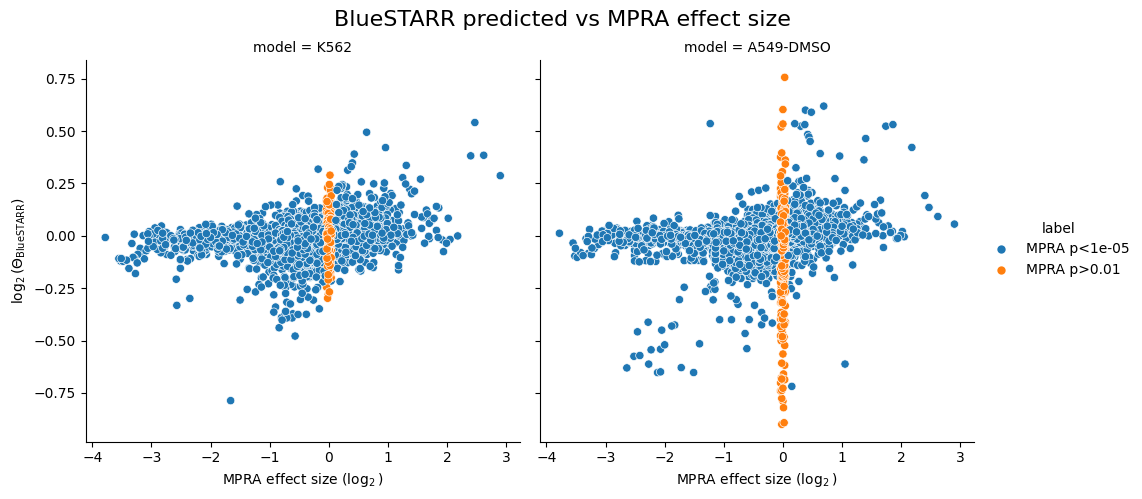

In [20]:
g = sns.relplot(data=bk_df, x='mpra_max_log2effect', y='log2FC',
                 hue='label', col='model', kind='scatter')
g.set_axis_labels('MPRA effect size ($\log_2)$', '$\log_2(\Theta_{\mathrm{BlueSTARR}})$')
g.figure.suptitle('BlueSTARR predicted vs MPRA effect size', fontsize=16)
g.figure.subplots_adjust(top=0.88)

### ROC curve display and AUC calculation


In [29]:
from sklearn.metrics import RocCurveDisplay, roc_curve, matthews_corrcoef

Text(0.5, 0.98, 'BlueSTARR effect prediction accuracy vs MPRA (Kircher et al. 2019)')

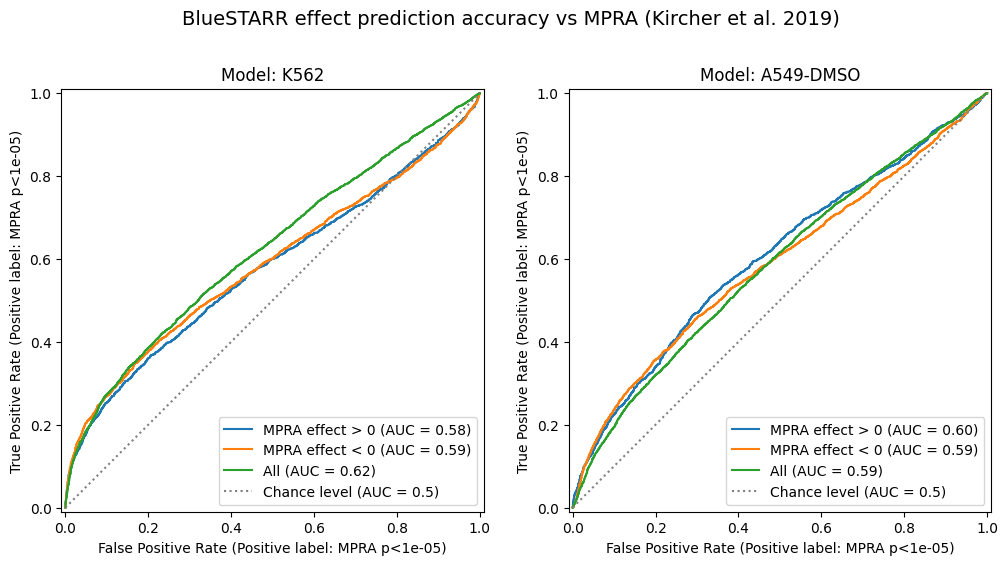

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, model in enumerate(bk_dfs.keys()):
    df_pos = bk_df_pos.xs(model, level='model')
    df_neg = bk_df_neg.xs(model, level='model')
    df_all = bk_df.xs(model, level='model')
    roc_pos = RocCurveDisplay.from_predictions(
        df_pos['label'],
        df_pos['log2FC'], pos_label=pos_label,
        name='MPRA effect > 0', ax=axs[i])
    roc_neg = RocCurveDisplay.from_predictions(
        df_neg['label'],
        -df_neg['log2FC'], pos_label=pos_label,
        name='MPRA effect < 0', ax=axs[i])
    roc_all = RocCurveDisplay.from_predictions(
        df_all['label'],
        df_all['abs_log2FC'], pos_label=pos_label,
        name='All', ax=axs[i],
        plot_chance_level=True, chance_level_kw={'linestyle': 'dotted', 'linewidth': 1.5, 'color': 'gray'})
    axs[i].set_title(f'Model: {model}')
fig.suptitle('BlueSTARR effect prediction accuracy vs MPRA (Kircher et al. 2019)', fontsize=14)


#### ROC curve and AUROC as per Kircher _et al_ (2019)

Kircher _et al_ in Supplementary Table 17 give AUC scores for a variety of classifiers, but in addition to the filtering (Tags >= 10; P<1e-5 for TPs; P>1e-5 and $\log_2$(expression effect) < 0.05 for TNs) their ROC computation uses only the top _N_, with $N \in \{200, 500, 1000\}$, variants with "highest expression effect", which we assume to be the absolute expression effect size in $\log_2$ space.

We repeat this way of subsetting the data here, too.

In [48]:
def topN_dataset(df, neg_label, N=1000, random_state=42):
    topN = df['mpra_max_log2effect'].abs().argsort()[-N:]
    return pd.concat([df.iloc[topN],
                      df.loc[df['label'] == neg_label].sample(N, random_state=random_state)],
                      ignore_index=True)

In [55]:
def roc_topN(df, neg_label, Ns=[1000,500,200], ax=None, include_full=True, print_precise=True, random_state=42):
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))
    rocs = {}
    if include_full:
        roc = RocCurveDisplay.from_predictions(
            df['label'],
            df['abs_log2FC'], pos_label=pos_label,
            name='All', ax=ax)
        rocs['All'] = roc
    df_topNs = {N: topN_dataset(df, neg_label=neg_label, N=N, random_state=random_state) for N in Ns}
    for N, df_topN in df_topNs.items():
        chance_level_args = dict(
            plot_chance_level=True,
            chance_level_kw={'linestyle': 'dotted', 'linewidth': 1.5, 'color': 'gray'}) if N == Ns[-1] else {}
        roc = RocCurveDisplay.from_predictions(
            df_topN['label'],
            df_topN['abs_log2FC'], pos_label=pos_label,
            name=f'MPRA Top-{N}', ax=ax,
            **chance_level_args)
        rocs[N] = roc
    if print_precise:
        print(f"  AUCs:")
        for N, roc in rocs.items():
            if type(N) == int:
                print(f"    Top {N:4} = {roc.roc_auc:.3f}")
            else:
                print(f"    {N} data = {roc.roc_auc:.3f}")
    return rocs, ax


In [57]:
def plot_rocs(df, models, neg_label):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    for i, model in enumerate(models):
        print(f"Model: {model}")
        _, ax = roc_topN(df.xs(model, level='model'), neg_label, ax=axs[i])
        ax.set_title(f'Model: {model}')
    return fig, axs

##### All regions together

Model: K562
  AUCs:
    All data = 0.622
    Top 1000 = 0.684
    Top  500 = 0.663
    Top  200 = 0.639
Model: A549-DMSO
  AUCs:
    All data = 0.585
    Top 1000 = 0.599
    Top  500 = 0.593
    Top  200 = 0.576


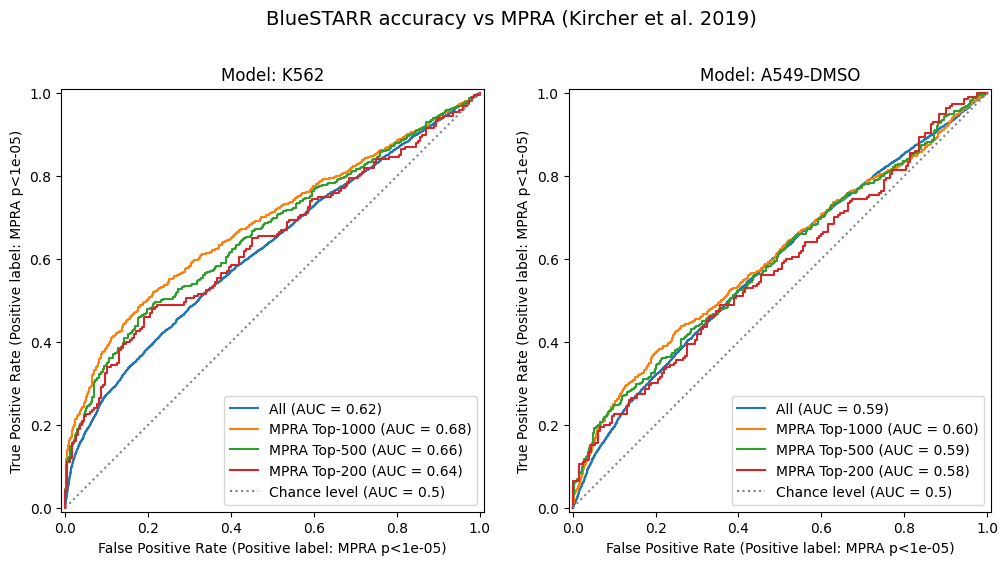

In [58]:
fig, _ = plot_rocs(bk_df, bk_dfs.keys(), neg_label)
_ = fig.suptitle('BlueSTARR accuracy vs MPRA (Kircher et al. 2019)', fontsize=14)


##### Enhancer and Promoter regions separated

Model: K562
  AUCs:
    All data = 0.588
    Top 1000 = 0.630
    Top  500 = 0.630
    Top  200 = 0.593
Model: A549-DMSO
  AUCs:
    All data = 0.598
    Top 1000 = 0.625
    Top  500 = 0.646
    Top  200 = 0.656


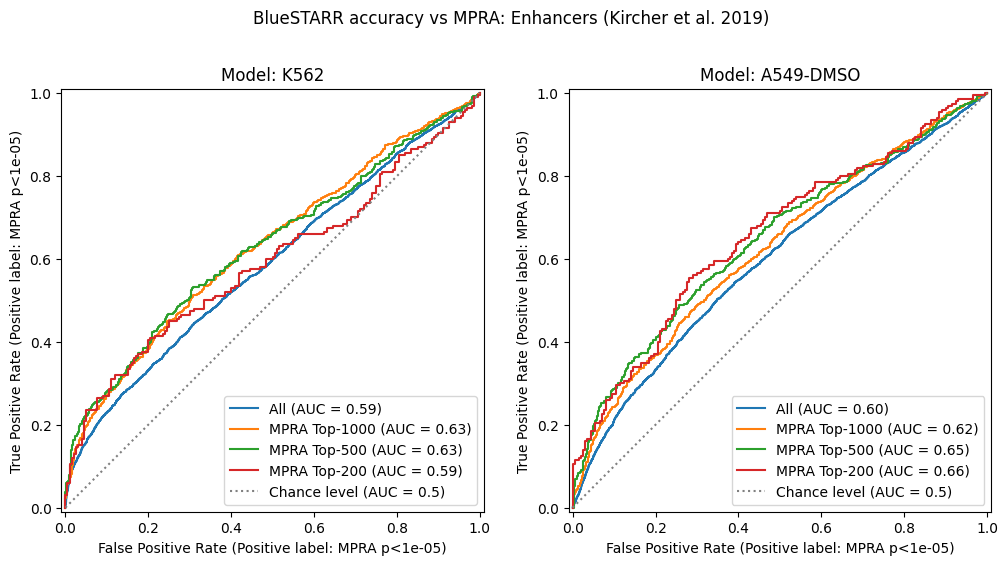

In [59]:
enh_df = bk_df.loc[bk_df['region_type'] == 'Enhancers']
fig, ax = plot_rocs(enh_df, bk_dfs.keys(), neg_label)
_ = fig.suptitle('BlueSTARR accuracy vs MPRA: Enhancers (Kircher et al. 2019)')

Model: K562
  AUCs:
    All data = 0.663
    Top 1000 = 0.716
    Top  500 = 0.703
    Top  200 = 0.710
Model: A549-DMSO
  AUCs:
    All data = 0.556
    Top 1000 = 0.575
    Top  500 = 0.536
    Top  200 = 0.496


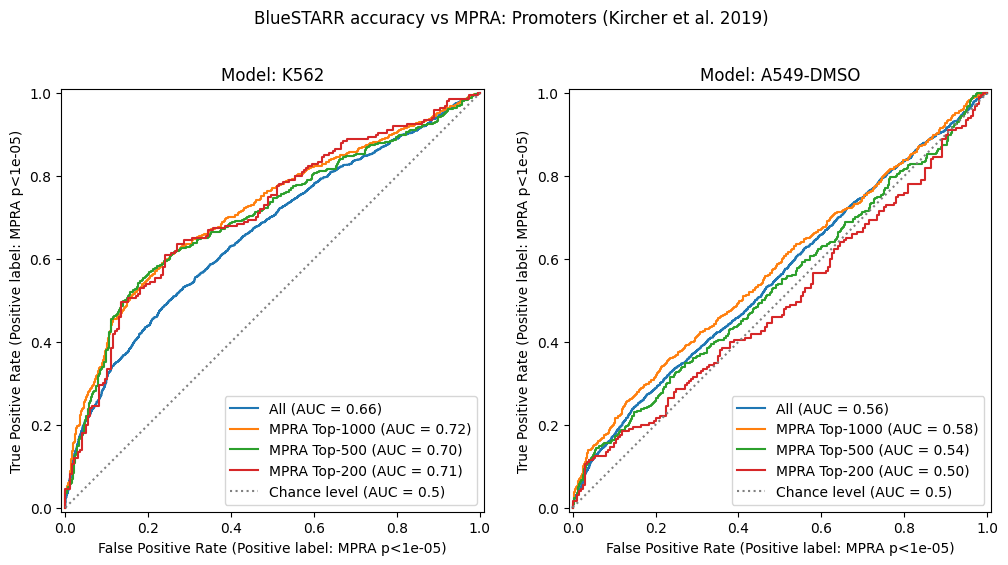

In [60]:
prom_df = bk_df.loc[bk_df['region_type'] == 'Promoters']
fig, ax = plot_rocs(prom_df, bk_dfs.keys(), neg_label)
_ = fig.suptitle('BlueSTARR accuracy vs MPRA: Promoters (Kircher et al. 2019)')